This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Zonal Statistics Example

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import xarray as xr

## Setup Examples

In [2]:
def testplot(ds, obj, col="mean",
             levels=[0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100],
             title=""):
    """Quick test plot layout for this example file
    """
    colors = pl.cm.viridis(np.linspace(0, 1, len(levels)))
    mycmap, mynorm = from_levels_and_colors(levels, colors, extend="max")

    radolevels = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100]
    radocolors = pl.cm.viridis(np.linspace(0, 1, len(radolevels)))
    radocmap, radonorm = from_levels_and_colors(radolevels, radocolors,
                                                extend="max")

    fig = pl.figure(figsize=(10, 16))

    # Average rainfall sum
    ax = fig.add_subplot(211, aspect="equal")
    obj.zdata.trg.geo.plot(column=col, ax=ax, 
                           cmap=mycmap, norm=mynorm, 
                           edgecolor="white", lw=0.5,
                           legend=True, legend_kwds=dict(shrink=0.5))
    ax.autoscale()
    pl.xlabel("UTM Zone 32 Easting")
    pl.ylabel("UTM Zone 32 Northing")
    pl.title(title)
    pl.draw()

    # Original radar data
    ax1 = fig.add_subplot(212, aspect="equal")
    pm = ds.plot(x="x", y="y", cmap=radocmap, norm=radonorm, ax=ax1, 
                 cbar_kwargs=dict(shrink=0.5))
    obj.zdata.trg.geo.plot(ax=ax1, facecolor="None", edgecolor="white")
    pl.xlabel("UTM Zone 32 Easting")
    pl.ylabel("UTM Zone 32 Northing")
    pl.title("Original radar rain sums")
    pl.draw()
    pl.tight_layout()

## Zonal Stats Rectangular Grid

In [3]:
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
import matplotlib.patches as patches
import datetime as dt
from osgeo import osr

In [4]:
# check for GEOS enabled GDAL
if not wrl.util.has_geos():
    print("NO GEOS support within GDAL, aborting...")
    exit(0)

In [5]:
# Read and prepare the actual data (RADOLAN)
f = wrl.util.get_wradlib_data_file(
    'radolan/misc/raa01-sf_10000-1406100050-dwd---bin.gz')
ds = wrl.io.open_radolan_dataset(f)

In [6]:
# create radolan projection osr object
proj_stereo = wrl.georef.create_osr("dwd-radolan")

# create UTM Zone 32 projection osr object
proj_utm = osr.SpatialReference()
proj_utm.ImportFromEPSG(32632)

# Source projection of the shape data (in GK2)
proj_gk2 = osr.SpatialReference()
proj_gk2.ImportFromEPSG(31466)

0

In [7]:
print(proj_gk2)

PROJCS["DHDN / 3-degree Gauss-Kruger zone 2",
    GEOGCS["DHDN",
        DATUM["Deutsches_Hauptdreiecksnetz",
            SPHEROID["Bessel 1841",6377397.155,299.1528128,
                AUTHORITY["EPSG","7004"]],
            AUTHORITY["EPSG","6314"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4314"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",6],
    PARAMETER["scale_factor",1],
    PARAMETER["false_easting",2500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Northing",NORTH],
    AXIS["Easting",EAST],
    AUTHORITY["EPSG","31466"]]


In [8]:
shpfile = wrl.util.get_wradlib_data_file(
    'shapefiles/agger/agger_merge.shp')
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2)
print(f"Found {len(trg)} sub-catchments in shapefile.")

Found 13 sub-catchments in shapefile.


In [9]:
print(trg.crs)

PROJCS["WGS 84 / UTM zone 32N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",9],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32632"]]


In [10]:
bbox = trg.extent
buffer = 5000.
bbox = dict(left=bbox[0] - buffer, right=bbox[1] + buffer,
            bottom=bbox[2] - buffer, top=bbox[3] + buffer)
print(bbox)

{'left': 365059.5928799211, 'right': 419830.11388741195, 'bottom': 5624046.706676126, 'top': 5668055.540990271}


In [11]:
# Get RADOLAN grid coordinates
x_rad, y_rad = np.meshgrid(ds.x, ds.y)
grid_xy_radolan = np.stack([x_rad, y_rad], axis=-1)

# Reproject the RADOLAN coordinates
xy = wrl.georef.reproject(grid_xy_radolan,
                          projection_source=proj_stereo,
                          projection_target=proj_utm)

# assign as coordinates
ds = ds.assign_coords({"xc": (["y", "x"], xy[..., 0], dict(long_name="UTM Zone 32 Easting", units="m")),
                       "yc": (["y", "x"], xy[..., 1], dict(long_name="UTM Zone 32 Northing", units="m"))})
ds_clip = ds.where((((ds.yc > bbox['bottom']) & (ds.yc < bbox['top'])) &
                    ((ds.xc > bbox['left']) & (ds.xc < bbox['right']))), drop=True)
display(ds_clip)

<xarray.Dataset>
Dimensions:  (y: 48, x: 58, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2014-06-10T00:50:00
  * y        (y) float64 -4.234e+03 -4.233e+03 ... -4.188e+03 -4.187e+03
  * x        (x) float64 -214.5 -213.5 -212.5 -211.5 ... -159.5 -158.5 -157.5
    xc       (y, x) float64 3.66e+05 3.669e+05 3.679e+05 ... 4.184e+05 4.193e+05
    yc       (y, x) float64 5.623e+06 5.623e+06 ... 5.669e+06 5.669e+06
Data variables:
    SF       (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    radarid:         10000
    radolanversion:  2.13.1
    radarlocations:  ['asw', 'boo', 'emd', 'han', 'umd', 'pro', 'ess', 'drs',...
    radardays:       ['asw 10', 'boo 24', 'drs 24', 'emd 24', 'ess 24', 'fbg ...

In [12]:
###########################################################################
# Approach #1: Assign grid points to each polygon and compute the average.
#
# - Uses matplotlib.path.Path
# - Each point is weighted equally (assumption: polygon >> grid cell)
# - this is quick, but theoretically dirty
###########################################################################

t1 = dt.datetime.now()

# Get RADOLAN center grid points for each grid cell
# (MUST BE DONE IN NATIVE RADOLAN COORDINATES)
grid_x, grid_y = np.meshgrid(ds_clip.x + 0.5, ds_clip.y + 0.5)
grdpoints = np.dstack([grid_x, grid_y]).reshape(-1, 2)

src = wrl.io.VectorSource(grdpoints, srs=proj_utm, name="src", projection_source=proj_stereo)
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2)

# Create instance of type ZonalDataPoint from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoint(src, trg, srs=proj_utm, buf=500.)
# dump to file (for later use - see below)
zd.dump_vector('test_zonal_points_cart')
# Create instance of type ZonalStatsPoint from zonal data object
obj1 = wrl.zonalstats.ZonalStatsPoint(zd)

isecs1 = obj1.zdata.isecs  # for plotting (see below)

t2 = dt.datetime.now()

t3 = dt.datetime.now()

# Create instance of type ZonalStatsPoint from zonal data file
# (much faster)
obj1 = wrl.zonalstats.ZonalStatsPoint('test_zonal_points_cart')

# Compute stats for target polygons
avg1 = obj1.mean(ds_clip.SF.values.ravel())
var1 = obj1.var(ds_clip.SF.values.ravel())


t4 = dt.datetime.now()

print("Approach #1 computation time:")
print("\tCreate object from scratch: %f "
      "seconds" % (t2 - t1).total_seconds())
print("\tCreate object from dumped file: %f "
      "seconds" % (t4 - t3).total_seconds())
print("\tCompute stats using object: %f "
      "seconds" % (t3 - t2).total_seconds())

# PLOTTING Approach #1

src = wrl.io.VectorSource(grdpoints, srs=proj_utm, name="src", projection_source=proj_stereo)
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2)
# Just a test for plotting results with zero buffer
zd2 = wrl.zonalstats.ZonalDataPoint(src, trg, buf=0)
# Create instance of type ZonalStatsPoint from zonal data object
obj2 = wrl.zonalstats.ZonalStatsPoint(zd2)
# copy attributes to target layer
obj2.zdata.trg.set_attribute("mean", avg1)
obj2.zdata.trg.set_attribute("var", var1)
isecs2 = obj2.zdata.isecs

Approach #1 computation time:
	Create object from scratch: 1.801533 seconds
	Create object from dumped file: 0.081224 seconds
	Compute stats using object: 0.000030 seconds


Text(0.5, 1.0, 'Catchment #6: Points considered for stats')

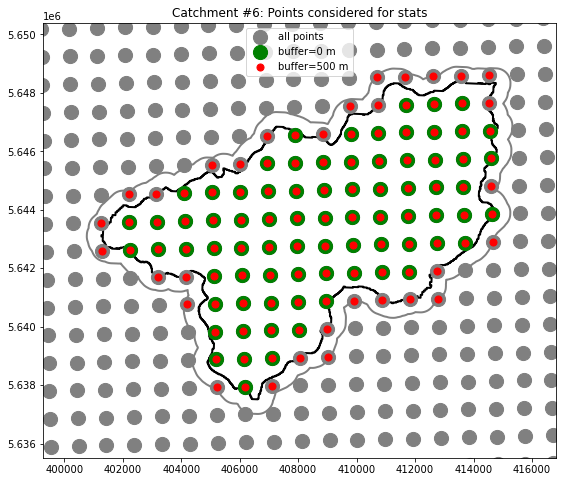

In [13]:
# Illustrate results for an example catchment i
i = 6  # try e.g. 5, 2
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, aspect="equal")

# Target polygon patches
trg_patch = obj2.zdata.trg.get_data_by_idx([i], mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="black", linewidth=2)
trg_patch = obj1.zdata.trg.get_data_by_idx([i], mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="grey", linewidth=2)

# pips
sources = obj1.zdata.src.geo
sources.plot(ax=ax, label="all points", c="grey", markersize=200)
isecs1 = obj2.zdata.dst.get_data_by_att(attr="trg_index", value=[i], mode="geo")
isecs1.plot(ax=ax, label="buffer=0 m", c="green", markersize=200)
isecs2 = obj1.zdata.dst.get_data_by_att(attr="trg_index", value=[i], mode="geo")
isecs2.plot(ax=ax, label="buffer=500 m", c="red", markersize=50)

cat = trg.get_data_by_idx([i])[0]
bbox = wrl.zonalstats.get_bbox(cat[..., 0], cat[..., 1])
pl.xlim(bbox["left"] - 2000, bbox["right"] + 2000)
pl.ylim(bbox["bottom"] - 2000, bbox["top"] + 2000)
pl.legend()
pl.title("Catchment #%d: Points considered for stats" % i)

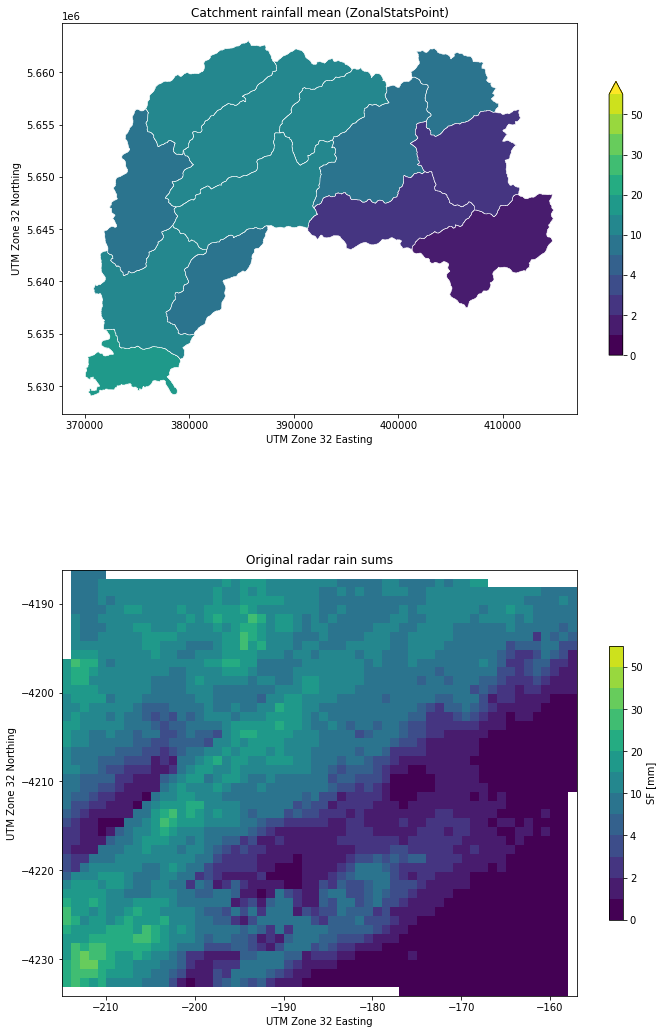

In [14]:
# Plot average rainfall and original data
testplot(ds_clip.SF, obj2, col="mean", title="Catchment rainfall mean (ZonalStatsPoint)")

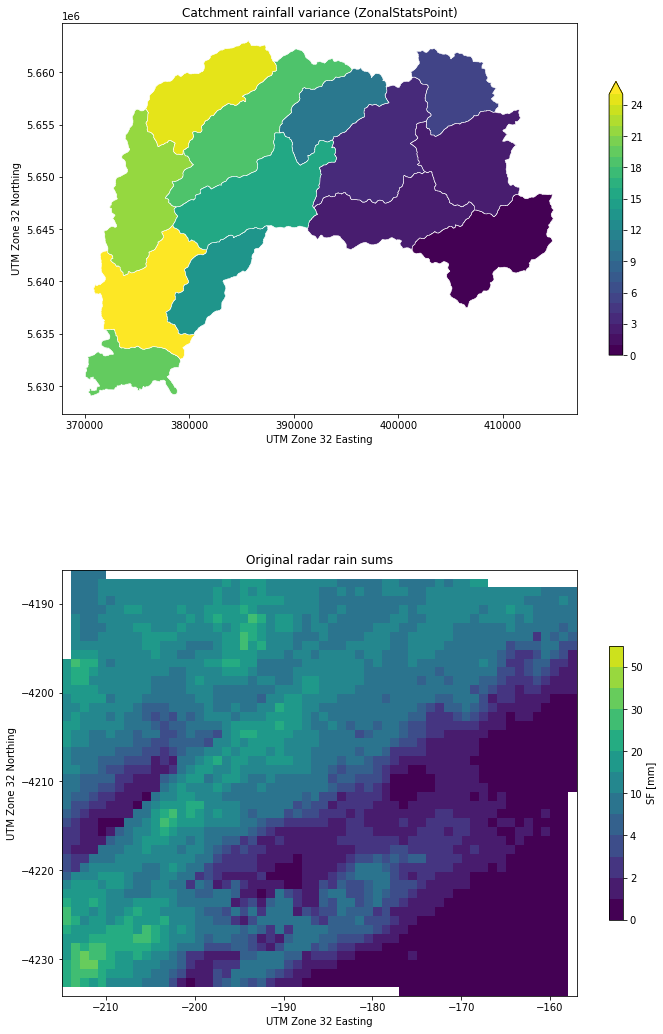

In [15]:
testplot(ds_clip.SF, obj2, col="var",
         levels=np.arange(0, np.max(var1), 1.),
         title="Catchment rainfall variance (ZonalStatsPoint)")

In [16]:
###########################################################################
# Approach #2: Compute weighted mean based on fraction of source polygons
# in target polygons
#
# - This is more accurate (no assumptions), but probably slower...
###########################################################################

# Create vertices for each grid cell
# (MUST BE DONE IN NATIVE RADOLAN COORDINATES)
grid_x, grid_y = np.meshgrid(ds_clip.x + 0.5, ds_clip.y + 0.5)
grdverts = wrl.zonalstats.grid_centers_to_vertices(grid_x,
                                                   grid_y, 
                                                   1., 1.)
# And reproject to Cartesian reference system (here: UTM Zone 32)
src = wrl.io.VectorSource(grdverts, srs=proj_utm, name="src", projection_source=proj_stereo)
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2)

t1 = dt.datetime.now()

# Create instance of type ZonalDataPoly from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoly(src, trg, srs=proj_utm)
# dump to file
zd.dump_vector('test_zonal_poly_cart')
# Create instance of type ZonalStatsPoint from zonal data object
obj3 = wrl.zonalstats.ZonalStatsPoly(zd)

t2 = dt.datetime.now()

t3 = dt.datetime.now()

# Create instance of type ZonalStatsPoly from zonal data file
obj3 = wrl.zonalstats.ZonalStatsPoly('test_zonal_poly_cart')
# Compute stats for target polygons
avg3 = obj3.mean(ds_clip.SF.values.ravel())
var3 = obj3.var(ds_clip.SF.values.ravel())

t4 = dt.datetime.now()

print("Approach #2 computation time:")
print("\tCreate object from scratch: %f "
      "seconds" % (t2 - t1).total_seconds())
print("\tCreate object from dumped file: %f "
      "seconds" % (t4 - t3).total_seconds())
print("\tCompute stats using object: %f "
      "seconds" % (t3 - t2).total_seconds())

Approach #2 computation time:
	Create object from scratch: 0.227418 seconds
	Create object from dumped file: 0.078643 seconds
	Compute stats using object: 0.000033 seconds


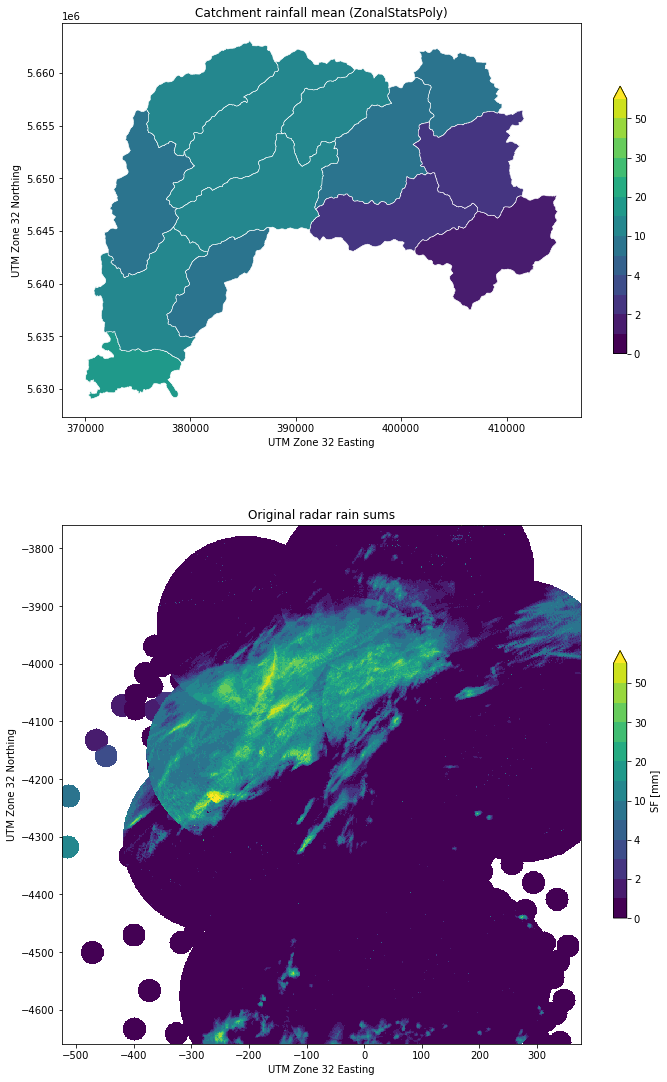

In [17]:
# PLOTTING Approach #2

# Plot average rainfall and original data
testplot(ds.SF, obj3, col="mean",
         title="Catchment rainfall mean (ZonalStatsPoly)")

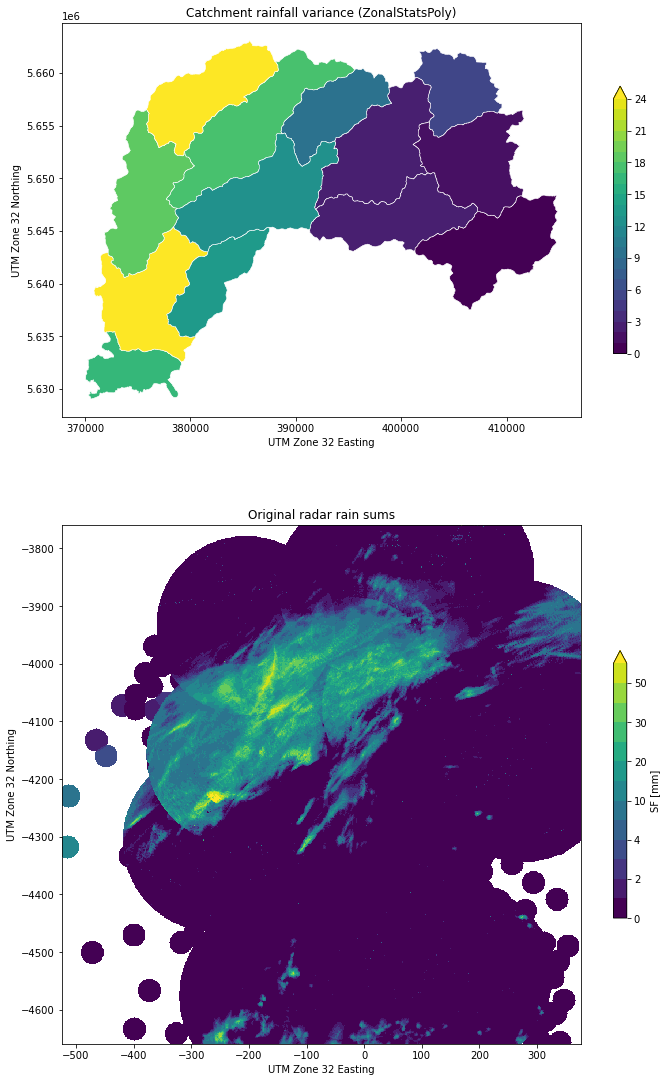

In [18]:
testplot(ds.SF, obj3, col="var",
         levels=np.arange(0, np.max(var3), 1.),
         title="Catchment rainfall variance (ZonalStatsPoly)")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Catchment #6: Polygons considered for stats')

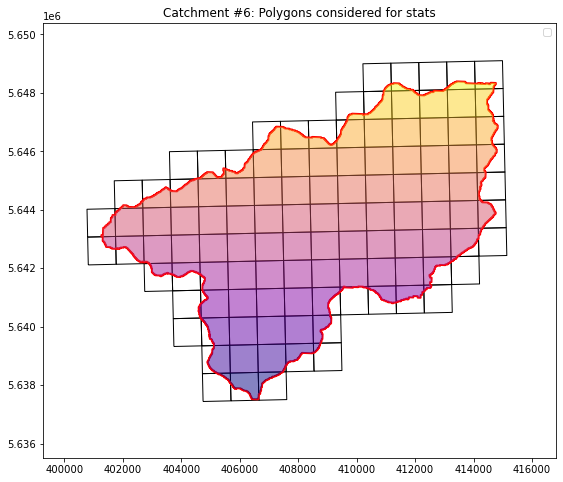

In [19]:
# Illustrate results for an example catchment i
i = 6  # try e.g. 5, 2
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, aspect="equal")

# Grid cell patches
src_index = obj3.zdata.get_source_index(i)
trg_patch = obj3.zdata.src.get_data_by_idx(src_index, mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="black")

# Target polygon patches
trg_patch = obj3.zdata.trg.get_data_by_idx([i], mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="red", linewidth=2)

# intersections
isecs1 = obj3.zdata.dst.get_data_by_att(attr="trg_index", value=[i], mode="geo")
isecs1.plot(column="src_index", ax=ax, cmap=pl.cm.plasma, alpha=0.5)

cat = trg.get_data_by_idx([i])[0]
bbox = wrl.zonalstats.get_bbox(cat[..., 0], cat[..., 1])
pl.xlim(bbox["left"] - 2000, bbox["right"] + 2000)
pl.ylim(bbox["bottom"] - 2000, bbox["top"] + 2000)
pl.legend()
pl.title("Catchment #%d: Polygons considered for stats" % i)

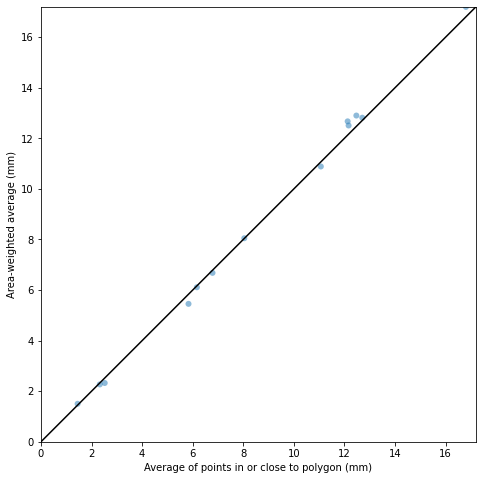

In [20]:
# Compare estimates
maxlim = np.max(np.concatenate((avg1, avg3)))
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, aspect="equal")
pl.scatter(avg1, avg3, edgecolor="None", alpha=0.5)
pl.xlabel("Average of points in or close to polygon (mm)")
pl.ylabel("Area-weighted average (mm)")
pl.xlim(0, maxlim)
pl.ylim(0, maxlim)
pl.plot([-1, maxlim + 1], [-1, maxlim + 1], color="black")
pl.show()

## Zonal Stats Polar Grid

In [21]:
def create_center_coords(ds, proj=None):
    # create polar grid centroids in GK2
    center = wrl.georef.spherical_to_centroids(ds.range.values, 
                                               ds.azimuth.values, 
                                               0.5, 
                                               (ds.longitude.values, ds.latitude.values, ds.altitude.values),
                                               proj=proj)
    ds = ds.assign_coords({"xc": (["azimuth", "range"], center[..., 0]),
                           "yc": (["azimuth", "range"], center[..., 1]),
                           "zc": (["azimuth", "range"], center[..., 2])})
    return ds
    

In [22]:
filename = wrl.util.get_wradlib_data_file('hdf5/rainsum_boxpol_20140609.h5')
ds = xr.open_dataset(filename)
ds = ds.rename_dims({"phony_dim_0": "azimuth", "phony_dim_1": "range"})
ds = ds.assign_coords({"latitude": ds.data.Latitude,
                       "longitude": ds.data.Longitude, 
                       "altitude": 99.5,
                       "azimuth": ds.data.az,
                       "range": ds.data.r,
                       "sweep_mode": "azimuth_surveillance",
                       "elevation": 0.5}
                     )

ds = ds.pipe(wrl.georef.georeference_dataset, proj=proj_utm)
ds = ds.pipe(create_center_coords, proj=proj_utm)
display(ds)

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 1000)
Coordinates: (12/16)
    latitude    float64 50.73
    longitude   float64 7.072
    altitude    float64 99.5
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * range       (range) float64 100.0 200.0 300.0 ... 9.98e+04 9.99e+04 1e+05
    sweep_mode  <U20 'azimuth_surveillance'
    ...          ...
    gr          (azimuth, range) float64 99.98 200.0 ... 9.986e+04 9.996e+04
    rays        (azimuth, range) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5
    bins        (azimuth, range) float64 100.0 200.0 300.0 ... 9.99e+04 1e+05
    xc          (azimuth, range) float64 3.639e+05 3.639e+05 ... 3.657e+05
    yc          (azimuth, range) float64 5.622e+06 5.622e+06 ... 5.722e+06
    zc          (azimuth, range) float64 100.0 100.9 ... 1.558e+03 1.56e+03
Data variables:
    data        (azimuth, range) float64 ...

In [23]:
# reshape
shpfile = wrl.util.get_wradlib_data_file('shapefiles/agger/agger_merge.shp')
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2)

bbox = trg.extent

# create catchment bounding box
buffer = 5000.
bbox = dict(left=bbox[0] - buffer, right=bbox[1] + buffer,
            bottom=bbox[2] - buffer, top=bbox[3] + buffer)

In [24]:
ds_clip = ds.where((((ds.yc > bbox['bottom']) & (ds.yc < bbox['top'])) &
                    ((ds.xc > bbox['left']) & (ds.xc < bbox['right']))), drop=True)
display(ds_clip)

<xarray.Dataset>
Dimensions:     (azimuth: 86, range: 695)
Coordinates: (12/16)
    latitude    float64 50.73
    longitude   float64 7.072
    altitude    float64 99.5
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 4.5 ... 82.5 83.5 84.5 85.5
  * range       (range) float64 2.8e+03 2.9e+03 3e+03 ... 7.21e+04 7.22e+04
    sweep_mode  <U20 'azimuth_surveillance'
    ...          ...
    gr          (azimuth, range) float64 2.799e+03 2.899e+03 ... 7.217e+04
    rays        (azimuth, range) float64 0.5 0.5 0.5 0.5 ... 85.5 85.5 85.5 85.5
    bins        (azimuth, range) float64 2.8e+03 2.9e+03 ... 7.21e+04 7.22e+04
    xc          (azimuth, range) float64 3.64e+05 3.64e+05 ... 4.359e+05
    yc          (azimuth, range) float64 5.624e+06 5.624e+06 ... 5.625e+06
    zc          (azimuth, range) float64 124.1 124.9 ... 1.034e+03 1.036e+03
Data variables:
    data        (azimuth, range) float64 nan nan nan nan nan ... nan nan nan nan

In [25]:
radar_utmc = np.dstack([ds_clip.xc, ds_clip.yc]).reshape(-1, 2)
radar_utmc.shape

(59770, 2)

In [26]:
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2)
src = wrl.io.VectorSource(radar_utmc, srs=proj_utm, name="src")

In [27]:
###########################################################################
# Approach #1: Assign grid points to each polygon and compute the average.
#
# - Uses matplotlib.path.Path
# - Each point is weighted equally (assumption: polygon >> grid cell)
# - this is quick, but theoretically dirty
# - for polar grids a range-area dependency has to be taken into account
###########################################################################

t1 = dt.datetime.now()

# Create instance of type ZonalDataPoint from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoint(src, trg, srs=proj_utm,
                                   buf=500.)
# dump to file
zd.dump_vector('test_zonal_points')
# Create instance of type ZonalStatsPoint from zonal data object
obj1 = wrl.zonalstats.ZonalStatsPoint(zd)

isecs1 = obj1.zdata.isecs
t2 = dt.datetime.now()

t3 = dt.datetime.now()

# Create instance of type ZonalStatsPoint from zonal data file
obj1 = wrl.zonalstats.ZonalStatsPoint('test_zonal_points')
# Compute stats for target polygons
avg1 = obj1.mean(ds_clip.data.values.ravel())
var1 = obj1.var(ds_clip.data.values.ravel())

t4 = dt.datetime.now()

print ("Approach #1 computation time:")
print(
"\tCreate object from scratch: %f seconds" % (t2 - t1).total_seconds())
print(
"\tCreate object from dumped file: %f seconds" % (t4 - t3).total_seconds())
print(
"\tCompute stats using object: %f seconds" % (t3 - t2).total_seconds())

Approach #1 computation time:
	Create object from scratch: 3.706262 seconds
	Create object from dumped file: 1.263752 seconds
	Compute stats using object: 0.000042 seconds


In [28]:
# PLOTTING Approach #2
src1 = wrl.io.VectorSource(radar_utmc, srs=proj_utm, name="src")
trg1 = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2)

# Just a test for plotting results with zero buffer
zd = wrl.zonalstats.ZonalDataPoint(src1, trg1, buf=0)
# Create instance of type ZonalStatsPoint from zonal data object
obj2 = wrl.zonalstats.ZonalStatsPoint(zd)
obj2.zdata.trg.set_attribute("mean", avg1)
obj2.zdata.trg.set_attribute("var", var1)

isecs2 = obj2.zdata.isecs

Text(0.5, 1.0, 'Catchment #0: Points considered for stats')

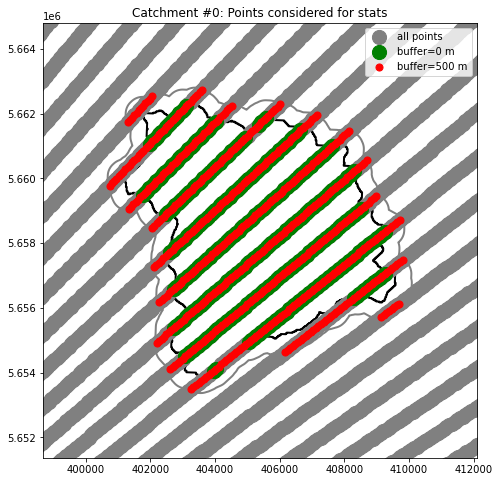

In [29]:
# Illustrate results for an example catchment i
i = 0  # try e.g. 5, 2
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, aspect="equal")

# Target polygon patches
trg_patch = obj2.zdata.trg.get_data_by_idx([i], mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="black", linewidth=2)
trg_patch = obj1.zdata.trg.get_data_by_idx([i], mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="grey", linewidth=2)

# pips
sources = obj1.zdata.src.geo
sources.plot(ax=ax, label="all points", c="grey", markersize=200)
isecs1 = obj2.zdata.dst.get_data_by_att(attr="trg_index", value=[i], mode="geo")
isecs1.plot(ax=ax, label="buffer=0 m", c="green", markersize=200)
isecs2 = obj1.zdata.dst.get_data_by_att(attr="trg_index", value=[i], mode="geo")
isecs2.plot(ax=ax, label="buffer=500 m", c="red", markersize=50)

cat = trg.get_data_by_idx([i])[0]
bbox = wrl.zonalstats.get_bbox(cat[..., 0], cat[..., 1])
pl.xlim(bbox["left"] - 2000, bbox["right"] + 2000)
pl.ylim(bbox["bottom"] - 2000, bbox["top"] + 2000)
pl.legend()
pl.title("Catchment #%d: Points considered for stats" % i)

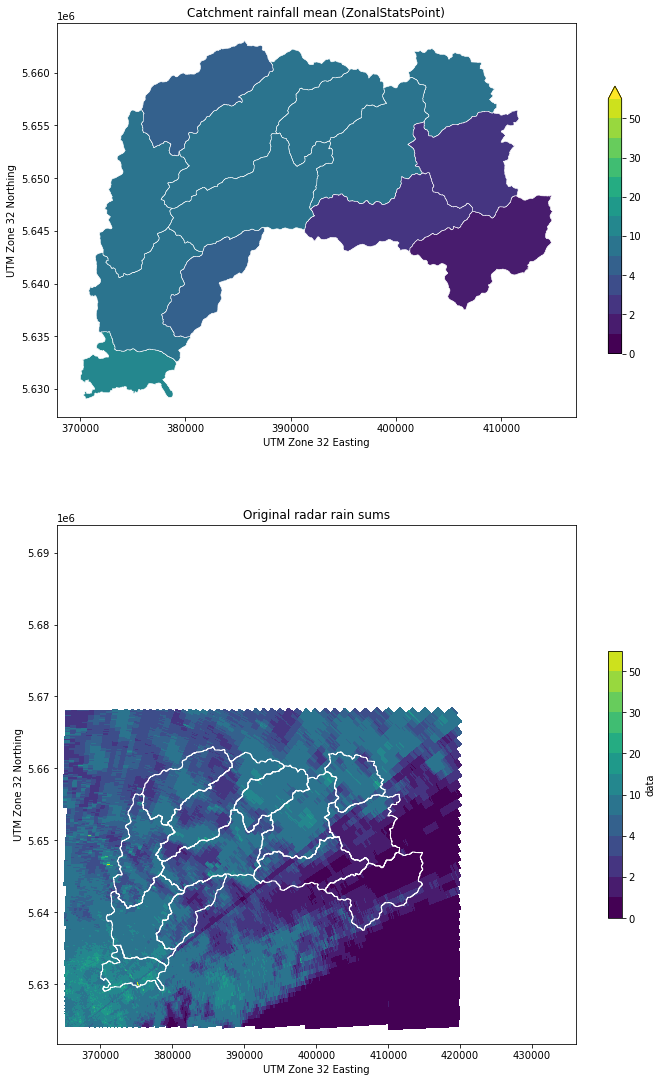

In [30]:
# Plot average rainfall and original data
testplot(ds_clip.data, obj2, col="mean",
         title="Catchment rainfall mean (ZonalStatsPoint)")

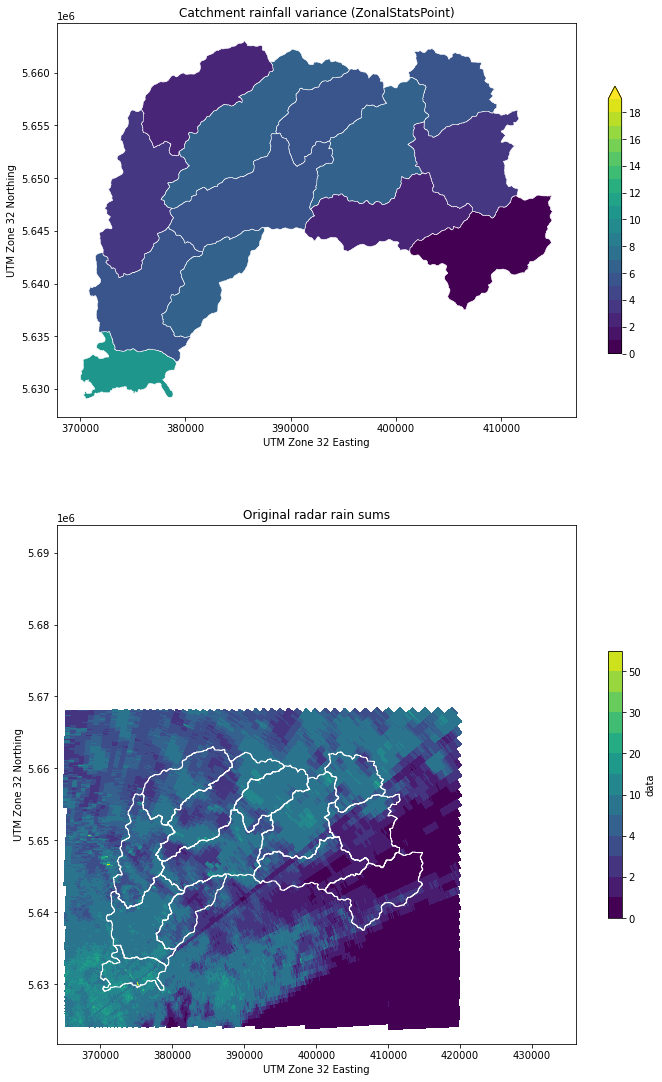

In [31]:
testplot(ds_clip.data, obj2, col="var", levels=np.arange(0, 20, 1.0),
         title="Catchment rainfall variance (ZonalStatsPoint)")

In [32]:
radar_utm = wrl.georef.spherical_to_polyvert(ds.range.values, 
                                 ds.azimuth.values, 
                                 0.5, 
                                 (ds.longitude.values, ds.latitude.values, ds.altitude.values),
                                 proj=proj_utm)
radar_utm.shape = (360, 1000, 5, 3)
ds = ds.assign_coords({"xp": (["azimuth", "range", "verts"], radar_utm[..., 0]),
                       "yp": (["azimuth", "range", "verts"], radar_utm[..., 1]),
                       "zp": (["azimuth", "range", "verts"], radar_utm[..., 2])})
display(ds)
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2)
bbox = trg.extent

# create catchment bounding box
buffer = 5000.
bbox = dict(left=bbox[0] - buffer, right=bbox[1] + buffer,
            bottom=bbox[2] - buffer, top=bbox[3] + buffer)
ds_clip = ds.where((((ds.yc > bbox['bottom']) & (ds.yc < bbox['top'])) &
                    ((ds.xc > bbox['left']) & (ds.xc < bbox['right']))), drop=True)
display(ds_clip)

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 1000, verts: 5)
Coordinates: (12/19)
    latitude    float64 50.73
    longitude   float64 7.072
    altitude    float64 99.5
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * range       (range) float64 100.0 200.0 300.0 ... 9.98e+04 9.99e+04 1e+05
    sweep_mode  <U20 'azimuth_surveillance'
    ...          ...
    xc          (azimuth, range) float64 3.639e+05 3.639e+05 ... 3.657e+05
    yc          (azimuth, range) float64 5.622e+06 5.622e+06 ... 5.722e+06
    zc          (azimuth, range) float64 100.0 100.9 ... 1.558e+03 1.56e+03
    xp          (azimuth, range, verts) float64 3.639e+05 ... 3.648e+05
    yp          (azimuth, range, verts) float64 5.622e+06 ... 5.721e+06
    zp          (azimuth, range, verts) float64 99.56 100.4 ... 1.559e+03
Dimensions without coordinates: verts
Data variables:
    data        (azimuth, range) float64 ...

<xarray.Dataset>
Dimensions:     (azimuth: 86, range: 695, verts: 5)
Coordinates: (12/19)
    latitude    float64 50.73
    longitude   float64 7.072
    altitude    float64 99.5
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 4.5 ... 82.5 83.5 84.5 85.5
  * range       (range) float64 2.8e+03 2.9e+03 3e+03 ... 7.21e+04 7.22e+04
    sweep_mode  <U20 'azimuth_surveillance'
    ...          ...
    xc          (azimuth, range) float64 3.64e+05 3.64e+05 ... 4.359e+05
    yc          (azimuth, range) float64 5.624e+06 5.624e+06 ... 5.625e+06
    zc          (azimuth, range) float64 124.1 124.9 ... 1.034e+03 1.036e+03
    xp          (azimuth, range, verts) float64 3.64e+05 3.64e+05 ... 4.358e+05
    yp          (azimuth, range, verts) float64 5.624e+06 ... 5.626e+06
    zp          (azimuth, range, verts) float64 123.6 124.5 ... 1.035e+03
Dimensions without coordinates: verts
Data variables:
    data        (azimuth, range) float64 nan nan nan nan nan ... nan nan nan nan

In [33]:
radar_utm = np.stack([ds_clip.xp, ds_clip.yp], axis=-1).reshape(-1, 5, 2)
print(radar_utm.shape)
src = wrl.io.VectorSource(radar_utm, srs=proj_utm, name="src")
trg = wrl.io.VectorSource(shpfile, srs=proj_utm, name="trg", projection_source=proj_gk2)

(59770, 5, 2)


In [34]:
###########################################################################
# Approach #2: Compute weighted mean based on fraction of source polygons
# in target polygons
#
# - This is more accurate (no assumptions), but probably slower...
###########################################################################

t1 = dt.datetime.now()

# Create instance of type ZonalDataPoly from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoly(src, trg, srs=proj_utm)
# dump to file
zd.dump_vector('test_zonal_poly')
# Create instance of type ZonalStatsPoint from zonal data object
obj3 = wrl.zonalstats.ZonalStatsPoly(zd)

obj3.zdata.dump_vector('test_zonal_poly')
t2 = dt.datetime.now()


t3 = dt.datetime.now()

# Create instance of type ZonalStatsPoly from zonal data file
obj4 = wrl.zonalstats.ZonalStatsPoly('test_zonal_poly')

avg3 = obj4.mean(ds_clip.data.values.ravel())
var3 = obj4.var(ds_clip.data.values.ravel())


t4 = dt.datetime.now()

print ("Approach #2 computation time:")
print(
"\tCreate object from scratch: %f seconds" % (t2 - t1).total_seconds())
print(
"\tCreate object from dumped file: %f seconds" % (t4 - t3).total_seconds())
print(
"\tCompute stats using object: %f seconds" % (t3 - t2).total_seconds())

obj3.zdata.trg.dump_raster('test_zonal_hdr.nc', 'netCDF', 'mean',
                           pixel_size=100.)

obj3.zdata.trg.dump_vector('test_zonal_shp')
obj3.zdata.trg.dump_vector('test_zonal_json.geojson', 'GeoJSON')

# Target polygon patches
trg_patches = [patches.Polygon(item, True) for item in obj3.zdata.trg.data]

Approach #2 computation time:
	Create object from scratch: 2.922166 seconds
	Create object from dumped file: 1.180934 seconds
	Compute stats using object: 0.000038 seconds


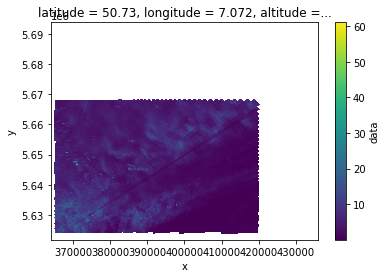

In [35]:
ds_clip.data.plot(x="x", y="y")

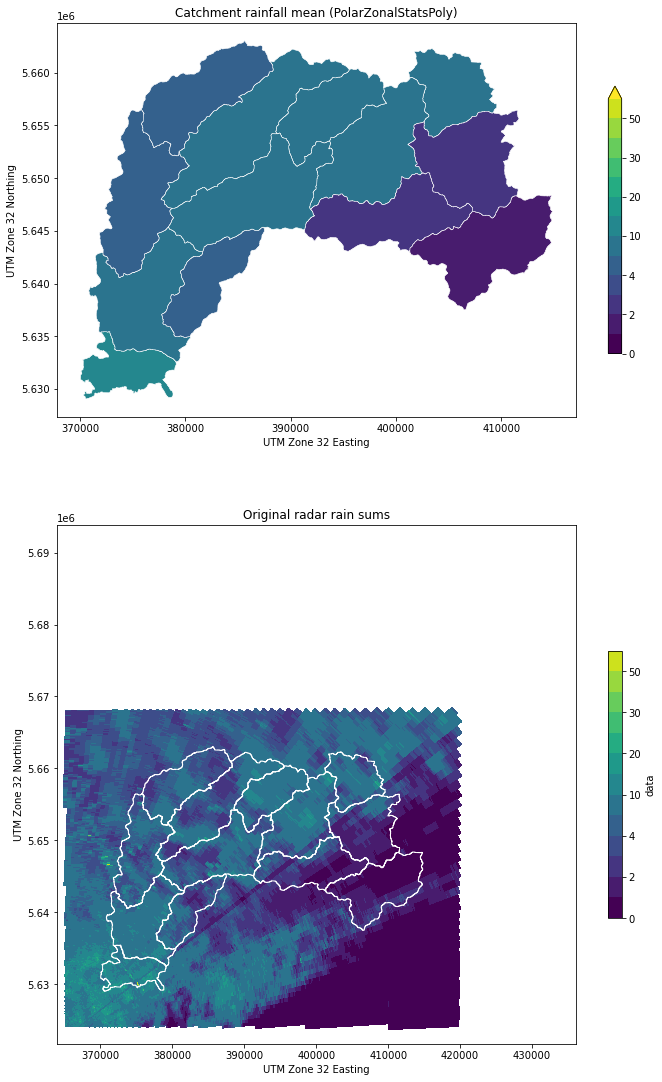

In [36]:
# Plot average rainfall and original data
testplot(ds_clip.data, obj4, col="mean",
         title="Catchment rainfall mean (PolarZonalStatsPoly)")

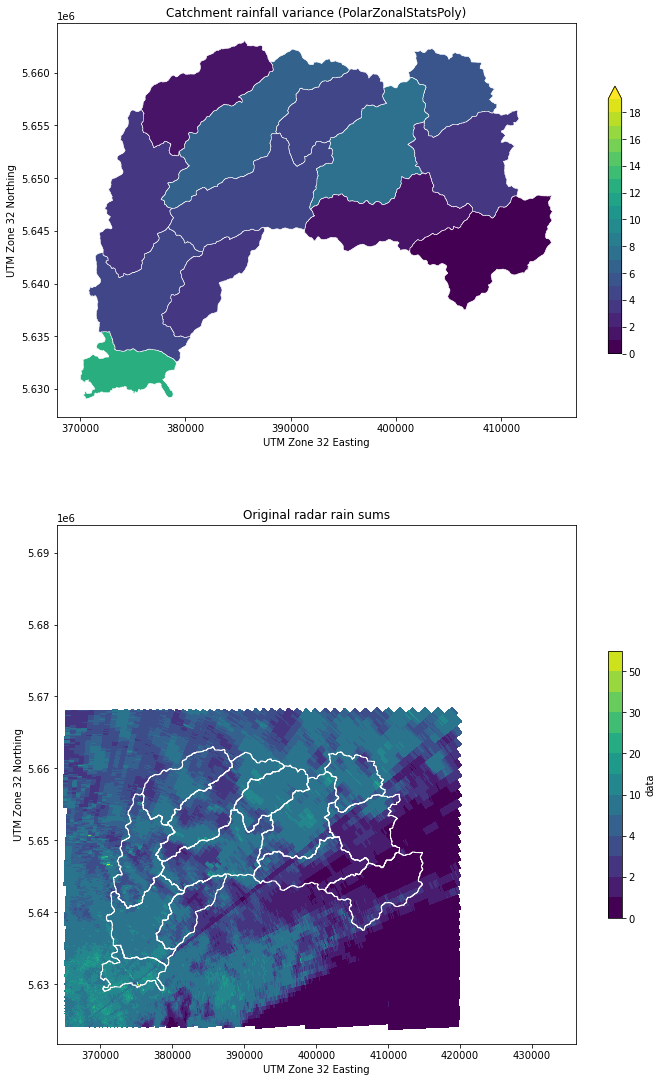

In [37]:
testplot(ds_clip.data, obj4, col="var", levels=np.arange(0, 20, 1.0),
         title="Catchment rainfall variance (PolarZonalStatsPoly)")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Catchment #0: Polygons considered for stats')

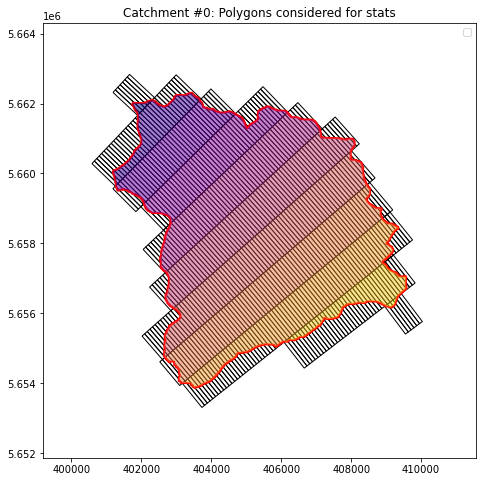

In [38]:
# Illustrate results for an example catchment i
i = 0  # try e.g. 5, 2
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, aspect="equal")

# Grid cell patches
src_index = obj3.zdata.get_source_index(i)
trg_patch = obj3.zdata.src.get_data_by_idx(src_index, mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="black")

# Target polygon patches
trg_patch = obj3.zdata.trg.get_data_by_idx([i], mode="geo")
trg_patch.plot(ax=ax, facecolor="None", edgecolor="red", linewidth=2)

# intersections
isecs1 = obj3.zdata.dst.get_data_by_att(attr="trg_index", value=[i], mode="geo")
isecs1.plot(column="src_index", ax=ax, cmap=pl.cm.plasma, alpha=0.5)

cat = trg.get_data_by_idx([i])[0]
bbox = wrl.zonalstats.get_bbox(cat[..., 0], cat[..., 1])
pl.xlim(bbox["left"] - 2000, bbox["right"] + 2000)
pl.ylim(bbox["bottom"] - 2000, bbox["top"] + 2000)
pl.legend()
pl.title("Catchment #%d: Polygons considered for stats" % i)

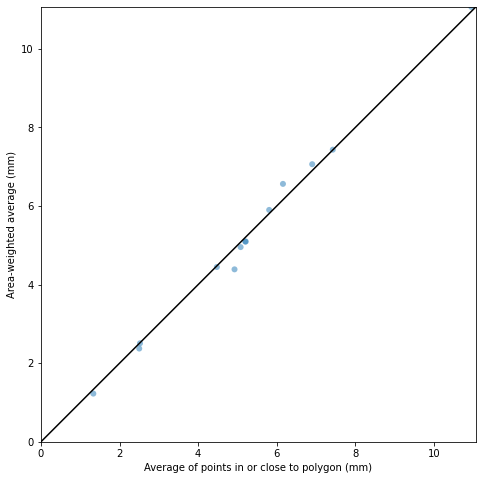

In [39]:
# Compare estimates
maxlim = np.max(np.concatenate((avg1, avg3)))
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, aspect="equal")
pl.scatter(avg1, avg3, edgecolor="None", alpha=0.5)
pl.xlabel("Average of points in or close to polygon (mm)")
pl.ylabel("Area-weighted average (mm)")
pl.xlim(0, maxlim)
pl.ylim(0, maxlim)
pl.plot([-1, maxlim + 1], [-1, maxlim + 1], color="black")
pl.show()